# Przygotowanie środowiska Collab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!apt-get install lzop --quiet
!pip3 install simplejson
!pip3 install transformers

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  lzop
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 39.8 kB of archives.
After this operation, 97.3 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 lzop amd64 1.03-4 [39.8 kB]
Fetched 39.8 kB in 0s (102 kB/s)
Selecting previously unselected package lzop.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../archives/lzop_1.03-4_amd64.deb ...
Unpacking lzop (1.03-4) ...
Setting up lzop (1.03-4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 133kB 4.8MB/s 


In [ ]:
%whos

Variable     Type             Data/Info
---------------------------------------
drive        module           <module 'google.colab.dri<...>s/google/colab/drive.py'>
fp           TextIOWrapper    <_io.TextIOWrapper name='<...>ode='r' encoding='UTF-8'>
graph_dict   dict             n=10628569
json         module           <module 'simplejson' from<...>/simplejson/__init__.py'>
np           module           <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
os           module           <module 'os' from '/usr/lib/python3.7/os.py'>
pd           module           <module 'pandas' from '/u<...>ages/pandas/__init__.py'>
plt          module           <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
sns          module           <module 'seaborn' from '/<...>ges/seaborn/__init__.py'>
subprocess   module           <module 'subprocess' from<...>python3.7/subprocess.py'>
tqdm         type             <class 'tqdm.notebook.tqdm_notebook'>


# Pobranie danych

In [ ]:
!cd /content/drive/Shareddrives/RecSys21/training && wget -i training_urls.txt

In [ ]:
!cd /content/drive/Shareddrives/RecSys21/ && wget https://storage.googleapis.com/twttr-recsys-2021-data/recsys2021/recsys_data/latest/training/tsv_deleted_engaged_with_tweet_id/part-00000
!cd /content/drive/Shareddrives/RecSys21/ && wget https://storage.googleapis.com/twttr-recsys-2021-data/recsys2021/recsys_data/latest/training/tsv_deleted_user_id/part-00000

# Wczytywanie jednej paczki do DataFrame

In [8]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
import simplejson as json

In [9]:
all_features = ["text_ tokens", "hashtags", "tweet_id", "present_media", "present_links", "present_domains",\
                "tweet_type","language", "tweet_timestamp", "engaged_with_user_id", "engaged_with_user_follower_count",\
               "engaged_with_user_following_count", "engaged_with_user_is_verified", "engaged_with_user_account_creation",\
               "enaging_user_id", "enaging_user_follower_count", "enaging_user_following_count", "enaging_user_is_verified",\
               "enaging_user_account_creation", "engagee_follows_engager"]
labels = ["reply_timestamp", "retweet_timestamp", "retweet_with_comment_timestamp", "like_timestamp"]

all_features_to_idx = dict(zip(all_features, range(len(all_features))))
labels_to_idx = dict(zip(labels, range(len(all_features), len(all_features)+len(labels))))

In [10]:
def unpack_to_df(package_name, sslice=None):
  out = subprocess.Popen(['lzop', '-dc', package_name], \
            stdout=subprocess.PIPE, \
            stderr=subprocess.STDOUT)
  lines, stderr = out.communicate()
  lines = lines.decode('utf-8').split('\n')
  if sslice is not None:
    lines = lines[sslice]
  lines = list(map(lambda line: line.split("\x01"), lines))
  lines = pd.DataFrame(lines, columns=all_features + labels)
  return lines

In [13]:
%%time

package_name = "/content/drive/Shareddrives/RecSys21/training/part-00000.lzo"
df = unpack_to_df(package_name)

CPU times: user 59.7 s, sys: 10.2 s, total: 1min 9s
Wall time: 1min 22s


# Podstawowe statystyki

In [ ]:
df.describe()

,text_ tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,enaging_user_id,enaging_user_follower_count,enaging_user_following_count,enaging_user_is_verified,enaging_user_account_creation,engagee_follows_engager,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp
count,3300771,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770
unique,2812148,315247,3041137,17,303962,56888,3,66,1449863,1619504,122982,30959,2,1615081,2303793,23358,13822,2,2291914,2,91987,265387,22783,925225
top,101\t100\t102,,AE62799DC2A663D542FB92AAF531E5D1,,,,TopLevel,488B32D24BD4BB44172EB981C1BCA6FA,1612752917,D956CB05C8566B63F75C86A595A84417,12399443,0,false,1267828720,DA0026BDA7CA28C0DB8A89BC0C783F55,0,96,false,1559503200,false,,,,
freq,14227,2632600,124,2041604,2920389,2920389,1952361,1204895,129,2240,2240,29847,2661568,2240,93,17552,7044,3294974,93,1931076,3206319,3012818,3277834,1992113


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

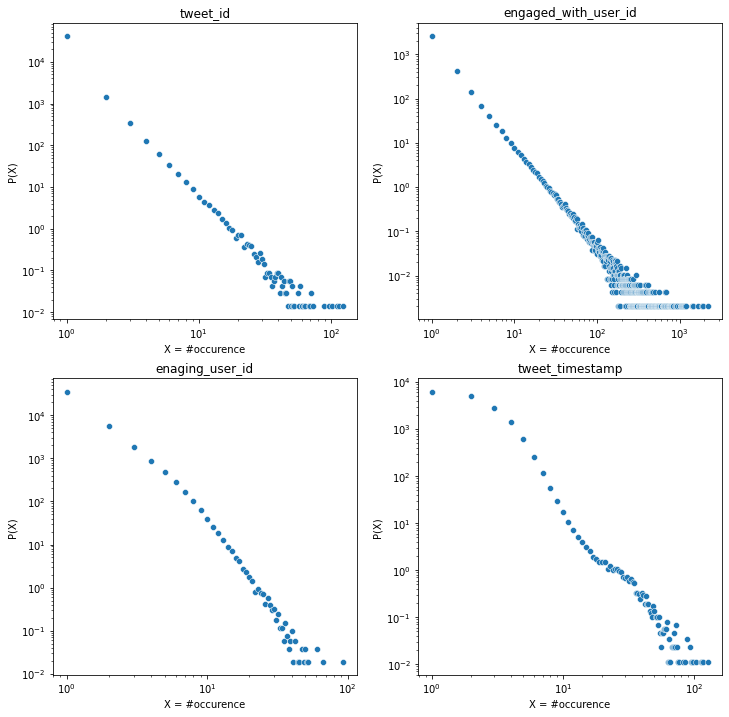

In [ ]:

fig, ax = plt.subplots(2,2, figsize=(20,12))
ax = ax.flatten()
cols = ["tweet_id", "engaged_with_user_id", "enaging_user_id", "tweet_timestamp"]
for i, col in enumerate(cols):
  unique, counts = np.unique(df[col].value_counts().values, return_counts=True)
  lp = sns.scatterplot(unique, counts / len(counts), ax=ax[i])
  lp.set_ylabel("P(X)")
  lp.set_xlabel("X = #occurence")
  lp.set_yscale("log")
  lp.set_xscale("log")
  lp.set_title(col)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

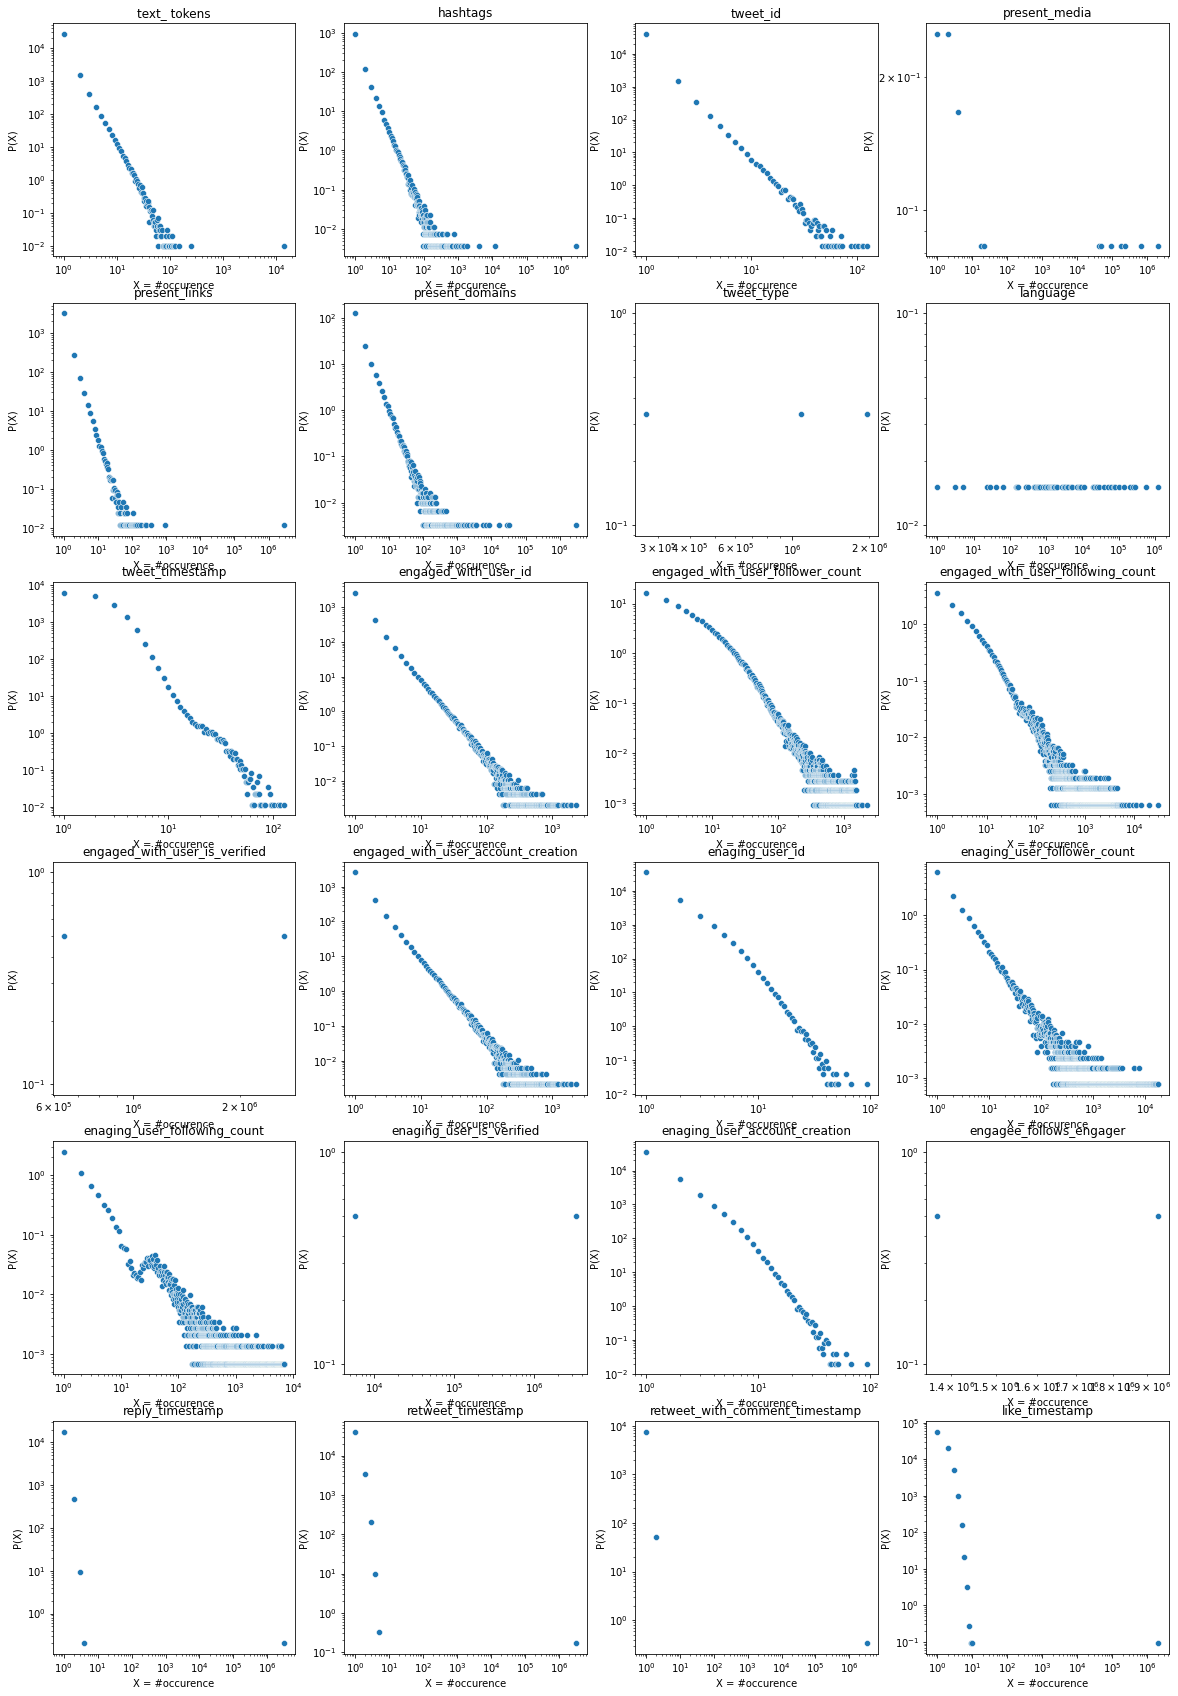

In [ ]:
fig, ax = plt.subplots(6,4, figsize=(20,30))
ax = ax.flatten()
cols = df.columns
for i, col in enumerate(cols):
  unique, counts = np.unique(df[col].value_counts().values, return_counts=True)
  lp = sns.scatterplot(unique, counts / len(counts), ax=ax[i])
  lp.set_ylabel("P(X)")
  lp.set_xlabel("X = #occurence")
  lp.set_yscale("log")
  lp.set_xscale("log")
  lp.set_title(col)
plt.show()

## Wzorce występujące w labelach

In [ ]:
label_patterns = df[labels].astype(bool).astype(str).agg('-'.join, axis=1).value_counts()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Log scale')

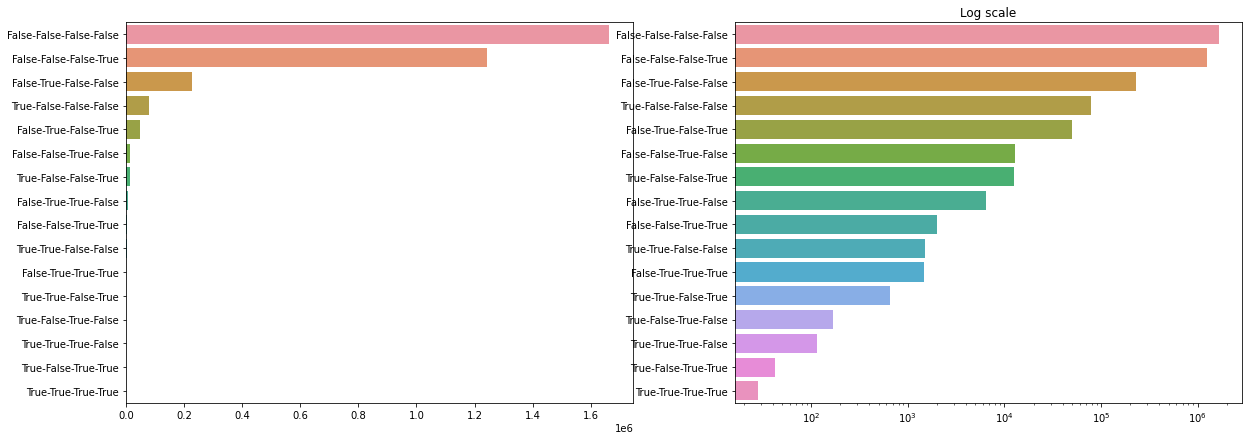

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
bp = sns.barplot(label_patterns,label_patterns.index, orient='h', ax=ax[0])
bp = sns.barplot(label_patterns,label_patterns.index, orient='h', ax=ax[1])
bp.set_xscale("log")
bp.set_title("Log scale")

## Relacje czasowe

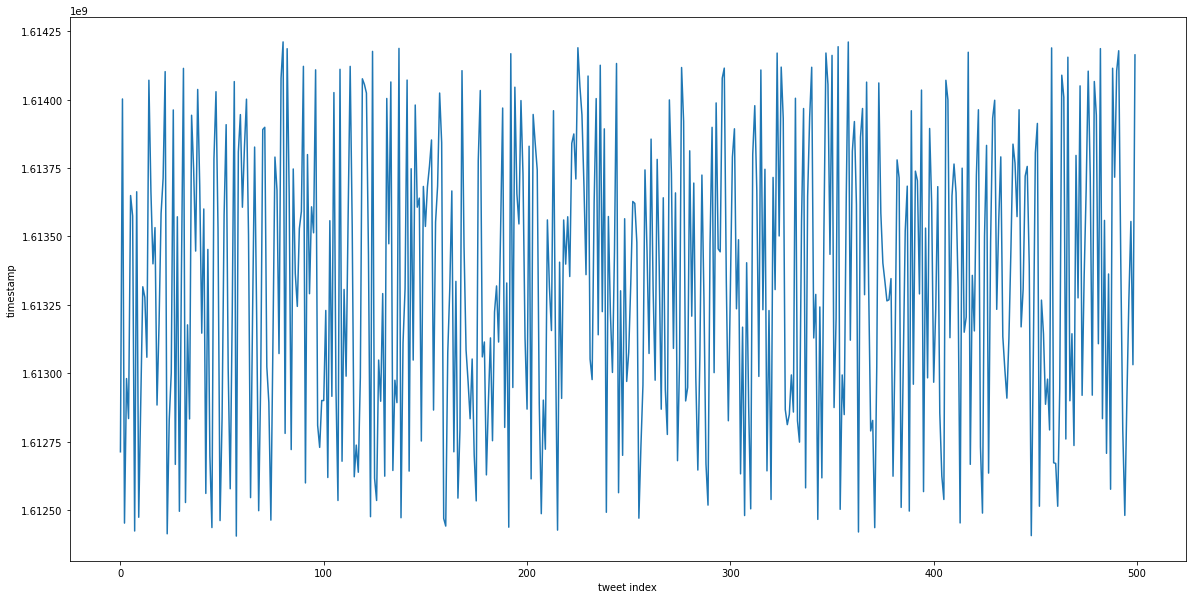

In [ ]:
x = df['tweet_timestamp'][:500].astype('int64')
plt.figure(figsize=(20,10))
plt.plot(range(len(x)), x)
plt.xlabel('tweet index')
plt.ylabel('timestamp')
plt.show()

In [ ]:
package_name_1 = "/content/drive/Shareddrives/RecSys21/training/part-00000.lzo?X-Goog-Algorithm=GOOG4-RSA-SHA256&X-Goog-Credential=recsys2021-website-service-acc@twttr-recsys-2021-dev.iam.gserviceaccount.com%2F20210411%2Fauto%2Fstorage%2Fgoog4_request&X-Goog-Date=20210411T115049Z&X-Goog-Expires=2592"
package_name_2 = "/content/drive/Shareddrives/RecSys21/training/part-00001.lzo?X-Goog-Algorithm=GOOG4-RSA-SHA256&X-Goog-Credential=recsys2021-website-service-acc@twttr-recsys-2021-dev.iam.gserviceaccount.com%2F20210411%2Fauto%2Fstorage%2Fgoog4_request&X-Goog-Date=20210411T115049Z&X-Goog-Expires=2592"

# Zabija sesję

# df2 = unpack_to_df(package_name_2)

# Idea - wczytywanie części df

df1 = unpack_to_df(package_name_1, sslice=slice(-251, -1)) # Nie mamy ostatniej reakcji w paczce
df2 = unpack_to_df(package_name_2, sslice=slice(0, 250))

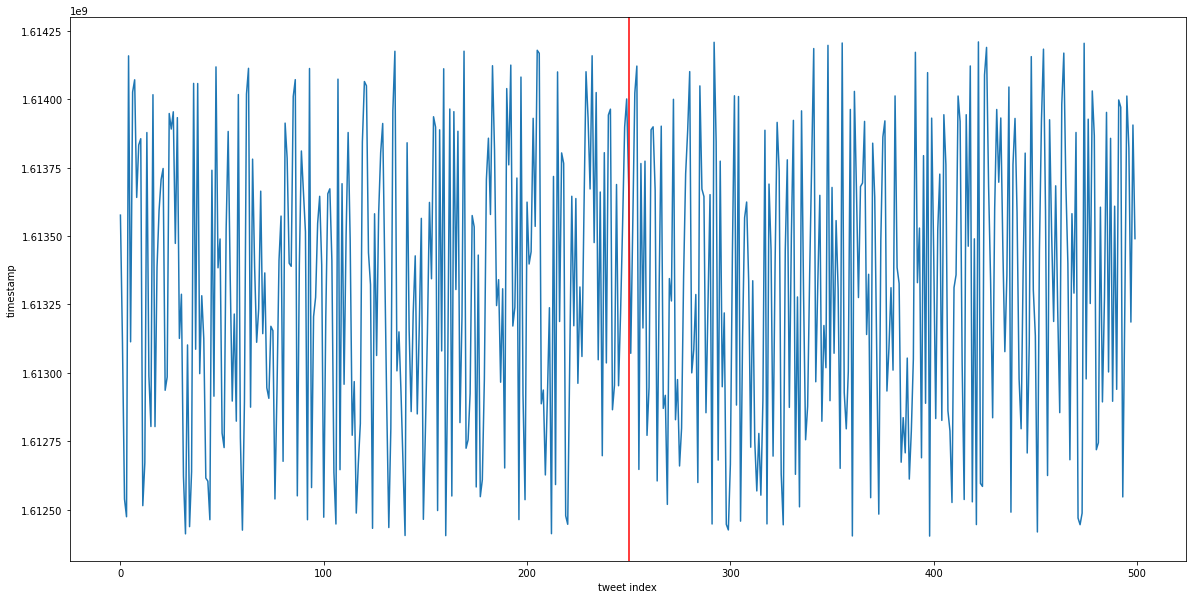

In [ ]:
# ostatnie 250 tweetów z pierwszej paczki (bez jednego ostatniego) i pierwsze 250 z kolejnej paczki
x = list(df1['tweet_timestamp'].astype('int64')) + list(df2['tweet_timestamp'].astype('int64'))
plt.figure(figsize=(20,10))
plt.plot(range(len(x)), x)
plt.axvline(250, color='red')
plt.xlabel('tweet index')
plt.ylabel('timestamp')
plt.show()

In [ ]:
# może po sortowaniu wszystkich reakcji według timestamp będzie lepiej? 

package_name_1 = "/content/drive/Shareddrives/RecSys21/training/part-00000.lzo?X-Goog-Algorithm=GOOG4-RSA-SHA256&X-Goog-Credential=recsys2021-website-service-acc@twttr-recsys-2021-dev.iam.gserviceaccount.com%2F20210411%2Fauto%2Fstorage%2Fgoog4_request&X-Goog-Date=20210411T115049Z&X-Goog-Expires=2592"
package_name_2 = "/content/drive/Shareddrives/RecSys21/training/part-00001.lzo?X-Goog-Algorithm=GOOG4-RSA-SHA256&X-Goog-Credential=recsys2021-website-service-acc@twttr-recsys-2021-dev.iam.gserviceaccount.com%2F20210411%2Fauto%2Fstorage%2Fgoog4_request&X-Goog-Date=20210411T115049Z&X-Goog-Expires=2592"

# bez tego znowu zabraknie pamięci
def get_timestamps(package_name):
  out = subprocess.Popen(['lzop', '-dc', package_name], \
            stdout=subprocess.PIPE, \
            stderr=subprocess.STDOUT)
  lines, stderr = out.communicate()
  lines = lines.decode('utf-8').split('\n')
  lines = lines[:-1] # last is empty
  feature_idx = all_features_to_idx['tweet_timestamp']
  timestamps = np.array(list(map(lambda line: line.split("\x01")[feature_idx], lines))).astype('int64')
  return timestamps

t1 = get_timestamps(package_name_1)
t2 = get_timestamps(package_name_2)

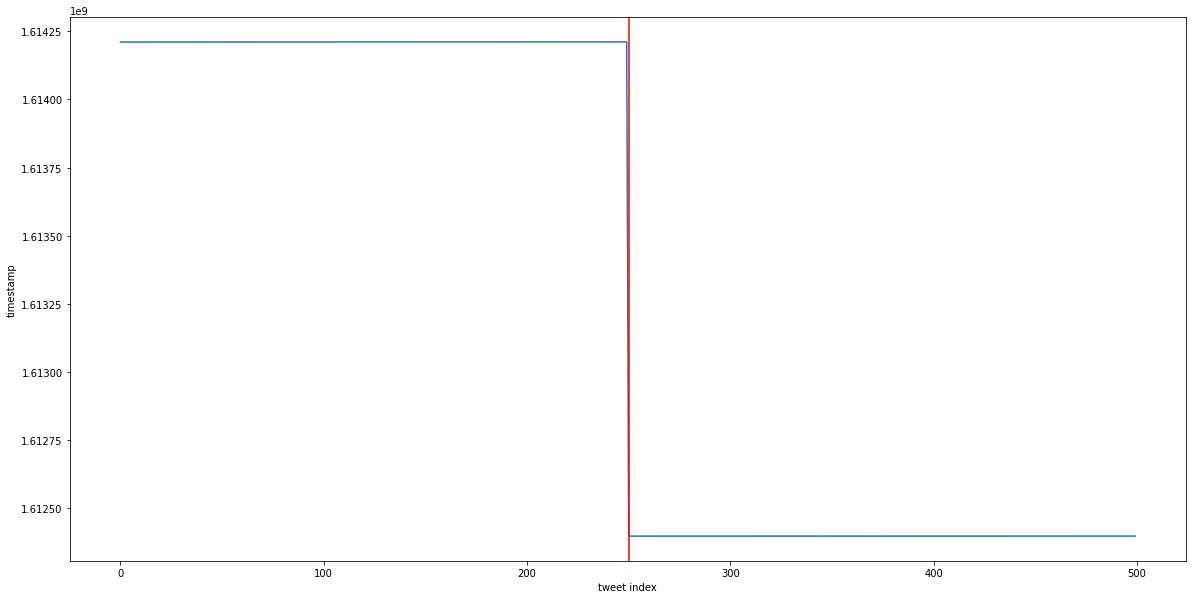

In [ ]:
last_t1 = np.sort(t1)[-250:]
first_t2 = np.sort(t2)[:250]
x = list(last_t1) + list(first_t2)
plt.figure(figsize=(20,10))
plt.plot(range(len(x)), x)
plt.axvline(250, color='red')
plt.xlabel('tweet index')
plt.ylabel('timestamp')
plt.show()

## Wnioski

### Dane
1. 3300770 reakcji
2. tweet_id != reakcję (92.13% unikalnych tweetów)
3. 17 typów media - 66.85% reakcji nie ma mediów
4. 88.47% reakcji nie zawiera linków (identycznie dla tweetów zawierające domeny)
5. 66 języków - 36,5% reakcji na tweety w najbardziej popularnym (angielski?)
6. Paczka zawiera 2240 reakcji dla jednego z "Engaged With" Usera
7. Średnio po dwie reakcji na "Engaged With" usera (49.06% unikalnych engaged_with_user_id)
8. Najpopularniejsza ilość osób, którą followuje "Engaged With" User dla reakcji w tej paczce  - 0 (0.9% takich reakcji)
9. 80.63% reakcji na nie zweryfikowane konta "Engaged With" userów 
10. Paczka zawiera 93 reakcji dla jednego z "Engaging" Usera
11. W 58.5% reakcjach "engagee" nie followuje "engagera"
12. Top wykonywanych akcji:
  * 50.4% - Żadnej akcji
  * 37.6% - tylko like
-----------------

### Zależności czasowe
1. Z ananlizy pierszych 500 tweetów wynika, że reakcje są nieposortowane czasowo
2. Pierwsze 250 tweeetów z paczki nie występują czasowo po pierszych 250 tweetach kolejnej paczki
3. 2 punkt zachodzi nawet jeśli posortujemy względem czasu reakcje w obu kolejnych paczkach
------------------

### Inne uwagi

1. Półtory minuty na wczytywanie paczki do pamięci na colabie
2. Wczytywanie dwóch paczek do pamięci na colabie zabija sesję - kończy się RAM

# Zbudowanie sieci użytkowników

In [ ]:
graph_dict = {}

In [ ]:
with open('/content/drive/Shareddrives/RecSys21/network_first_10.json', 'r') as fp:
    graph_dict = {k: set(v) for k,v in json.load(fp).items()}

In [ ]:
def update_graph_dict(package_name):
  global graph_dict
  lines = []
  del lines
  lines = subprocess.Popen(['lzop', '-dc', package_name], \
            stdout=subprocess.PIPE, \
            stderr=subprocess.STDOUT)\
            .communicate()[0] \
            .decode('utf-8') \
            .split('\n')[:-1]
  for line in lines:
    engaged_with_user_id, enaging_user_id, engagee_follows_engager = \
      np.take(line.split("\x01"), (9,14,19))
    if engagee_follows_engager:
      try:
        graph_dict[enaging_user_id].add(engaged_with_user_id)
      except:
        graph_dict[enaging_user_id] = set()
        graph_dict[enaging_user_id].add(engaged_with_user_id)

In [ ]:
%%time

files = sorted(list(filter(lambda f: f.startswith("part") and not f.split(".")[2].startswith("index"), os.listdir("/content/drive/Shareddrives/RecSys21/training/"))))

pbar = tqdm(total=4)
for f in files[10:14]:
  update_graph_dict("/content/drive/Shareddrives/RecSys21/training/" + f)
  pbar.update(1)
pbar.close()

In [ ]:
with open('/content/drive/Shareddrives/RecSys21/network.json', 'w') as fp:
    json.dump(graph_dict, fp, iterable_as_array=True)

In [ ]:
keys = list(graph_dict.keys())[:30]

for k in keys:
  print("User {} has {} followers ".format(k, len(graph_dict[k])))

User 761EDF35532C3D3758DD01D33619D243 has 36 followers 
User AE8B92F8CFE9F92C2942DEBBFE4F0FCF has 17 followers 
User ED5574665DB1478CA23F13647178D9BE has 3 followers 
User 585F08165162A5C10DE2081ECFACCFC0 has 10 followers 
User CAD64086EF823706DEF953E615DB6743 has 2 followers 
User 41BD1385BB51D31C6E3D317F7EE3625A has 36 followers 
User 7843EF89DEC5C0DD7D952F414232C77A has 21 followers 
User A95C2553D90D1F06261F29D307C079BC has 21 followers 
User 88AFCF8593B72DAE90C76431DE80FE8B has 6 followers 
User E8619B69BEF407F9BAEF9905714E6829 has 43 followers 
User ECF9E3F668B44507A184D38330388559 has 1 followers 
User 7731B77E430A19B01754C20428AD06DC has 4 followers 
User 781C2D1A552E436738CBDADB64AE142D has 4 followers 
User 12E55E8F9F094A3C17C56FD7B239640D has 14 followers 
User 60EC1B362786FCE9B3545B5D019327E2 has 27 followers 
User 9623FC1E74B81D704A2A21C691227C9A has 1 followers 
User 7884BE22508AAAFC4AF2691CEA404CA5 has 8 followers 
User 4809418677FA1A0B0AA5415097501D1F has 15 followers 


In [ ]:
len(graph_dict.keys())

10628569

# Decode twitter

In [26]:
import torch
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
for tokens in df.loc[:20, "text_ tokens"]:
  print(tokenizer.decode(tokens.split("\t")))

[CLS] RT @ sakuramt6 : [UNK] # みかじ 絵 https : / / t. co / UdWRUepkMQ [SEP]
[CLS] Oh well, next stop Rotterdam @ janniksin, hope to see you play there. : ) [SEP]
[CLS]... replacing Ares with Athena [UNK] [SEP]
[CLS] Which [UNK] will [UNK] you [UNK] get [UNK] first? https : / / t. co / VMzG9d3XCC [SEP]
[CLS] RT @ BrainzNBoobiez : Whew... this just gave me chills... # TheWaitIsOver [SEP]
[CLS] Diktaturmegafonen [SEP]
[CLS] # CivilDisobedienceMovement ¶ # JusticeForMyanmar https : / / t. co / rCiRJADZOW [SEP]
[CLS] RT @ mystarplay : [UNK] # 스타플레이 # 3월 # 생일투표 1 / [UNK] ¶ [UNK] # 3월생일 # [UNK] ¶ ¶ [UNK] ¶ [UNK] 초대형 생일전광판 ¶ [UNK] 파르나스몰 미디어패널 ( 39개 ) ¶ [UNK] ¶ ¶ [UNK] ¶ [UNK] ¶ ¶ # starplay 앱에서 [UNK] [SEP]
[CLS] RT @ FaseehMangi : Pakistan fiscal deficit rises to 2. 5 % in six months vs 2. 3 %, some key numbers : ¶ Tax revenue [UNK] - 0. 4 % ¶ Government expenditures [UNK] [SEP]
[CLS] The Right will push conspiracy theories and fascistic fearmongering until it stops being profitable or costs the